In [1]:
# Import necessary Libraries
import numpy as np
import pandas as pd

import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
%matplotlib inline

# For warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install pyexcel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 6.0 MB/s eta 0:00:00


In [3]:
# To read, write, and manipulate data in excel formats
import pyexcel

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/TimeSeries

/content/drive/MyDrive/TimeSeries


In [6]:
# Initialising variables
data = []
headers = ['Date', 'crypto1', 'crypto2', 'zscore', 'signal', 'status',
           'buy price', 'sell price', 'mtm', 'pnl', 'Cointegration test']

data.append(headers)

# Tolerance for the stdev above and below the mean
threshold = 1.75

start = 80
end = 90
prev_status = ""
mtm = ""
prev_sell_price = ""
sell_price = ""
prev_buy_price = ""
buy_price = ""
SL = -10000
TP = 20000

# Lot size for data1
N = 5000
# Lot size for data2
M = 5000

In [7]:
# Read the bitcoin data
asset1_price = pd.read_csv('ADA-USD.csv', index_col='Date')

# Set the index to datetime format
asset1_price.index = pd.to_datetime(asset1_price.index)

# Read the ETH data
asset2_price = pd.read_csv('DOGE-USD.csv', index_col='Date')

# Set the index to datetime format
asset2_price.index = pd.to_datetime(asset2_price.index)

In [8]:
asset1_price.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-24,0.089706,0.091354,0.082314,0.082754,0.082754,89522100.0
2018-09-25,0.082303,0.082303,0.075378,0.081028,0.081028,87535200.0
2018-09-26,0.080992,0.082871,0.077172,0.079476,0.079476,64321400.0
2018-09-27,0.079466,0.087636,0.078421,0.086001,0.086001,101911000.0
2018-09-28,0.086403,0.088327,0.082045,0.084032,0.084032,89113600.0


In [9]:
asset1_price.drop('Adj Close',axis=1)

,Open,High,Low,Close,Volume
Date,,,,,
2018-09-24,0.089706,0.091354,0.082314,0.082754,89522100.0
2018-09-25,0.082303,0.082303,0.075378,0.081028,87535200.0
2018-09-26,0.080992,0.082871,0.077172,0.079476,64321400.0
2018-09-27,0.079466,0.087636,0.078421,0.086001,101911000.0
2018-09-28,0.086403,0.088327,0.082045,0.084032,89113600.0
...,...,...,...,...,...
2023-09-20,NaN,NaN,NaN,NaN,NaN
2023-09-21,NaN,NaN,NaN,NaN,NaN
2023-09-22,NaN,NaN,NaN,NaN,NaN


In [10]:
asset2_price.drop('Adj Close',axis=1)

,Open,High,Low,Close,Volume
Date,,,,,
2018-09-24,0.005904,0.006067,0.005659,0.005677,17243600.0
2018-09-25,0.005680,0.005794,0.005587,0.005686,17598700.0
2018-09-26,0.005692,0.005753,0.005662,0.005695,11673600.0
2018-09-27,0.005702,0.005910,0.005693,0.005879,15096200.0
2018-09-28,0.005864,0.005965,0.005783,0.005831,14461600.0
...,...,...,...,...,...
2023-09-20,NaN,NaN,NaN,NaN,NaN
2023-09-21,NaN,NaN,NaN,NaN,NaN
2023-09-22,NaN,NaN,NaN,NaN,NaN


In [11]:
# Drop nan columns
asset1_price = asset1_price.dropna()
asset2_price = asset2_price.dropna()

# To make the data uniform date wise
asset1_price['key'] = asset1_price.index
asset2_price['key'] = asset2_price.index

# Merge dataframes to find common dates
result = pd.merge(asset1_price, asset2_price,
                  left_index=True, right_index=True)

asset1_price = result[['Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x']]
asset2_price = result[['Open_y', 'High_y', 'Low_y', 'Close_y', 'Volume_y']]

# Rename the columns
asset1_price.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Rename the columns
asset2_price.columns = ['Open', 'High', 'Low', 'Close','Volume']

In [12]:
asset1_price.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2018-09-24,0.089706,0.091354,0.082314,0.082754,89522100.0
2018-09-25,0.082303,0.082303,0.075378,0.081028,87535200.0
2018-09-26,0.080992,0.082871,0.077172,0.079476,64321400.0
2018-09-27,0.079466,0.087636,0.078421,0.086001,101911000.0
2018-09-28,0.086403,0.088327,0.082045,0.084032,89113600.0


In [13]:
asset2_price.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2018-09-24,0.005904,0.006067,0.005659,0.005677,17243600.0
2018-09-25,0.005680,0.005794,0.005587,0.005686,17598700.0
2018-09-26,0.005692,0.005753,0.005662,0.005695,11673600.0
2018-09-27,0.005702,0.005910,0.005693,0.005879,15096200.0
2018-09-28,0.005864,0.005965,0.005783,0.005831,14461600.0


In [14]:
asset1_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1823 entries, 2018-09-24 to 2023-09-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1823 non-null   float64
 1   High    1823 non-null   float64
 2   Low     1823 non-null   float64
 3   Close   1823 non-null   float64
 4   Volume  1823 non-null   float64
dtypes: float64(5)
memory usage: 150.0 KB


In [15]:
asset2_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1823 entries, 2018-09-24 to 2023-09-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1823 non-null   float64
 1   High    1823 non-null   float64
 2   Low     1823 non-null   float64
 3   Close   1823 non-null   float64
 4   Volume  1823 non-null   float64
dtypes: float64(5)
memory usage: 150.0 KB


In [16]:
# Define cointegration test function
def cointegration_test(x, y):

    # Use OLS method to find the spread of the two series
    result = stat.OLS(x['Close'], y['Close']).fit()

    # Check for stationarity of the spread using adfuller test
    return ts.adfuller(result.resid)

In [17]:
# Define z-score calculation function
def zscore_cal(data1, data2, start, end):

    s1 = pd.Series(data1['Close'][start:end])
    s2 = pd.Series(data2['Close'][start:end])

    # Compute mean of the spread till now
    mvavg_old = np.mean(np.log(s1/s2))

    # Compute stdev of the spread till now
    std_old = np.std(np.log(s1/s2))

    # Compute spread
    current_spread = np.log(
        data1['Close'][end]/data2['Close'][end])

    # Compute z-score
    zscore = (current_spread - mvavg_old) / \
        std_old if std_old > 0 else 0

    return zscore

In [18]:
# Generate trading signals
def signal_cal(zscore, threshold, adftest):

    # Z-score is greater than threshold, the spread shall fall towards mean
    if zscore > threshold and adftest == 'Yes':
        signal = 'SELL'

    # Z-score is smaller than threshold, the spread shall rise towards mean
    elif zscore < -threshold and adftest == 'Yes':
        signal = 'BUY'

    else:
        signal = ''

    return signal

In [19]:
# Define status
#SL = Stop Loss, TP = Take Profit, CB = Co-integration Break
def status_cal(prev_status, mtm, SL, TP, signal, adftest):
    if prev_status in ["", "SL", "TP", "CB"]:
        status = signal
    else:
        if adftest == "No":
            # Break in the cointegration status of the pair
            status = "CB"
        else:
            if mtm == "":
                status = ""
            else:
                if mtm < SL:
                    # Stop loss status
                    status = "SL"
                else:
                    if mtm > TP:
                        # Take profit status
                        status = "TP"
                    else:
                        status = prev_status

    return status

In [20]:
# Calculate buy price
def buy_price_cal(prev_status, prev_buy_price, buy_price, signal, status, data1, data2, end):

    if status == prev_status:
        buy_price = prev_buy_price

    else:
        if status in ["SL", "TP", "CB", ""]:
            buy_price = ""
        else:
            # Signal is to buy the spread
            if signal == "BUY":
                # Hence, buy price = close of first security
                buy_price = data1['Close'][end]
            else:
                # Signal is to sell the spread
                if signal == "SELL":
                    # Hence, buy price = close of second security
                    buy_price = data2['Close'][end]
                else:
                    # no signal hence no buy price
                    buy_price = ""

    return buy_price

In [23]:
# Calculate sell price
def sell_price_cal(prev_status, prev_sell_price, sell_price, signal, status, data1, data2, end):
    if status == prev_status:
        sell_price = prev_sell_price
    else:
        if status in ["SL", "TP", "CB", ""]:
            sell_price = ""
        else:
            if signal == "BUY":
                sell_price = data2['Close'][end]
            else:
                if signal == "SELL":
                    sell_price = data1['Close'][end]
                else:
                    sell_price = ""

    return sell_price

In [22]:
# Calculate mtm
def mtm_cal(data1, data2, prev_status, prev_sell_price, prev_buy_price, M, N, end):

    if prev_status == "BUY":
        # Calculate mtm of the trades using their lot sizes
        mtm = (prev_sell_price-data2['Close'][end])*M + (data1['Close'][end] -
                                                         prev_buy_price)*N
    else:
        if prev_status == "SELL":
            # Calculate mtm of the trades using their lot sizes
            mtm = (prev_sell_price-data1['Close'][end])*N + (data2['Close'][end]
                                                             - prev_buy_price)*M
        else:
            mtm = ""

    return mtm

In [24]:
# Define the strategy function to execute the pairs trading program
def strategy(data1, data2, threshold, start, end, prev_status, mtm, prev_sell_price,
             sell_price, prev_buy_price, buy_price, SL, TP, M, N):
    pnl = 0
    i = 0
    for row in data1[90:].iterrows():

        # Run the ADF test for each day, starting from day 91
        d1 = data1[i:90+i]
        d2 = data2[i:90+i]
        c_t = cointegration_test(d1, d2)
        if c_t[0] <= c_t[4]['10%'] and c_t[1] <= 0.1:
            adftest = "Yes"
        else:
            adftest = "No"

        # Calculate z-score
        zscore = zscore_cal(data1, data2, start, end)

        # Generate trading signals
        signal = signal_cal(zscore, threshold, adftest)

        # Calculate mtm
        mtm = mtm_cal(data1, data2, prev_status, prev_sell_price,
                      prev_buy_price, M, N, end)

        # Assign status
        status = status_cal(prev_status, mtm, SL, TP, signal, adftest)

        # Assign buy_price
        buy_price = buy_price_cal(prev_status, prev_buy_price, buy_price,
                                  signal, status, data1, data2, end)

        # Assign sell_price
        sell_price = sell_price_cal(prev_status, prev_sell_price, sell_price,
                                    signal, status, data1, data2, end)

        # Calculate pnl
        pnl = (pnl + mtm) if status in ["TP", "SL", "CB"] else pnl

        # Assign prev values
        prev_sell_price = sell_price
        prev_status = status
        prev_buy_price = buy_price

        # Append calculations to the data array
        data.append([str(data1.index[end])[:10], data1['Close'][end],
                     data2['Close'][end], zscore, signal, status, buy_price,
                     sell_price, mtm, pnl, adftest])

        # Increment variables to consider the next set of data
        end = end+1
        start = start+1
        i = i+1

    # Save to a CSV for debugging
    pyexcel.save_as(
        array=data, dest_file_name='pair_strategy_output.csv')

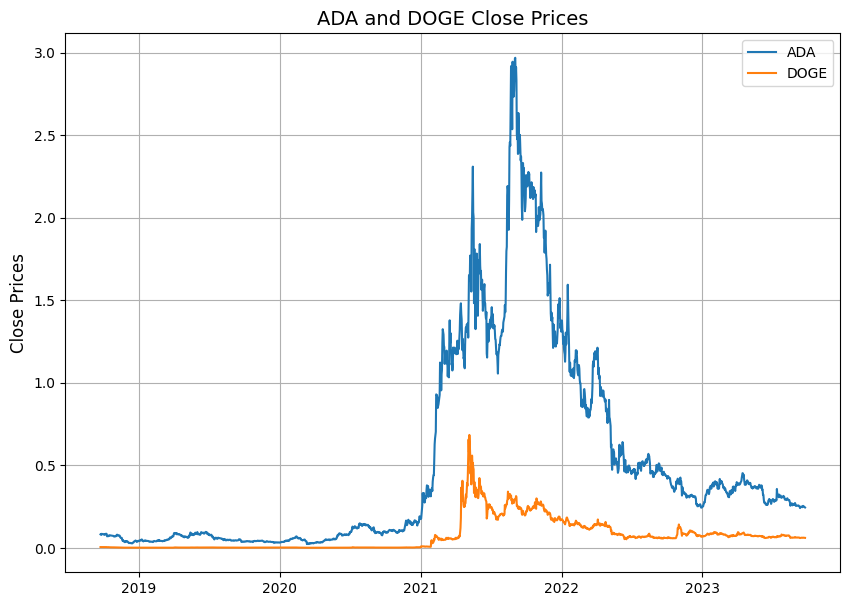

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Plot Closing price of data1
ax.plot(asset1_price.index, asset1_price.Close, label='ADA')

# Plot Closing price of data2
ax.plot(asset2_price.index, asset2_price.Close, label='DOGE')

# Define labels for x-axis and y-axis
plt.legend()
plt.ylabel('Close Prices', fontsize=12)
plt.ylabel('Close Prices', fontsize=12)
plt.title('ADA and DOGE Close Prices', fontsize=14)

# Display the major grid
plt.grid()

# Display the plot
plt.show()

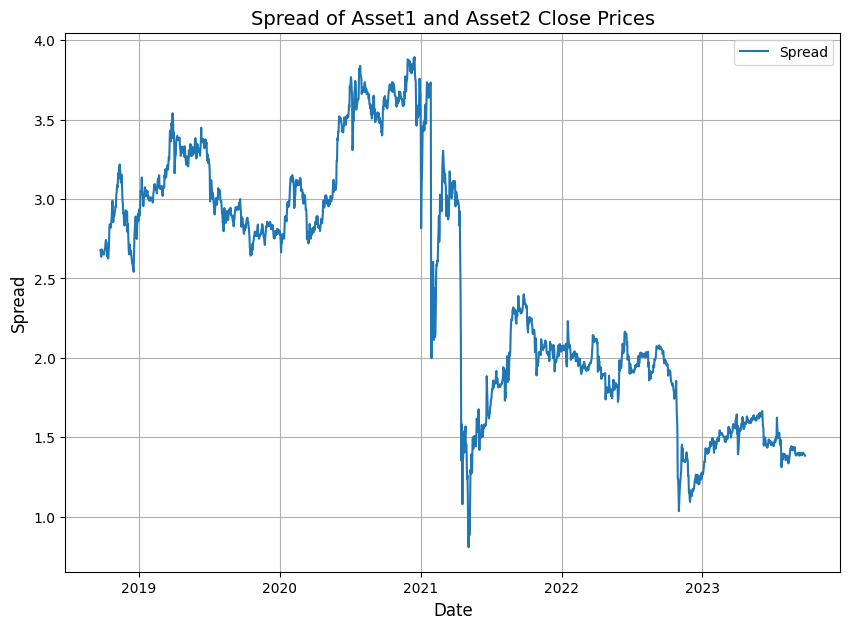

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Plot the spread
ax.plot(asset1_price.index, np.log(
    asset1_price.Close.values/asset2_price.Close.values), label='Spread')

plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spread', fontsize=12)
plt.title('Spread of Asset1 and Asset2 Close Prices', fontsize=14)
plt.grid()
plt.show()

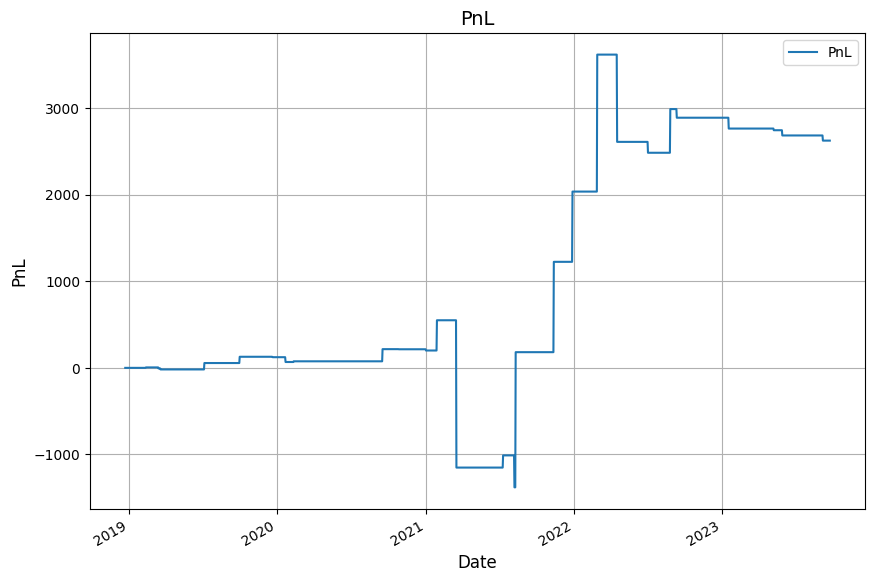

In [27]:
# Run the strategy
strategy(asset1_price,asset2_price,threshold,start,end,prev_status,mtm,prev_sell_price,\
             sell_price,prev_buy_price,buy_price,SL,TP,M,N)

result = pd.DataFrame(data, columns=headers)[1:]
result.set_index('Date',inplace=True)

# Convert index to a datetime index
result.index = pd.to_datetime(result.index)

result.pnl.plot(figsize=(10,7), label ='PnL')
plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('PnL', fontsize=12)
plt.title('PnL', fontsize=14)
plt.grid()
plt.show()